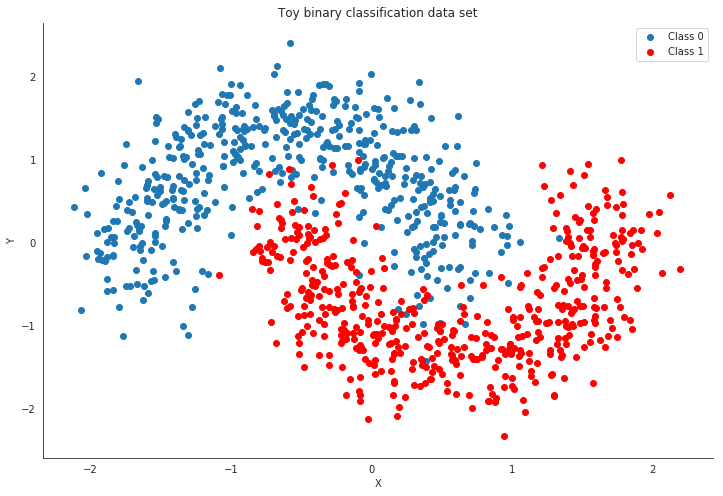

In [41]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(float)
Y = Y.astype(float)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [42]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

Average Loss = 187.6: 100%|██████████| 50000/50000 [00:51<00:00, 969.95it/s]  
Finished [100%]: Average Loss = 187.66


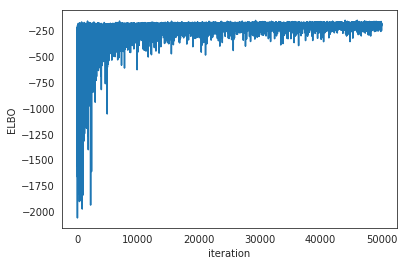

In [22]:
#from pymc3.theanof import set_tt_rng, MRG_RandomStreams
#set_tt_rng(MRG_RandomStreams(42))
#%time
# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output) 
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)
trace = approx.sample(draws=5000)
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

Accuracy = 86.6%


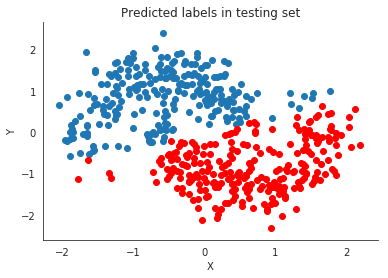

In [23]:
# Replace arrays our NN references with the test data
ann_input.set_value(X_test)
ann_output.set_value(Y_test)
 
with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)
 
# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Average Loss = 12.658: 100%|██████████| 50000/50000 [00:35<00:00, 1428.41it/s]
Finished [100%]: Average Loss = 12.66


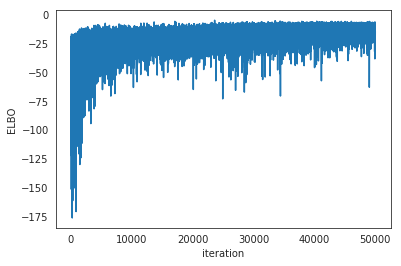

In [43]:
#批量训练
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(50000, method=inference)
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');
#pm.traceplot(trace);

In [54]:
# Replace arrays our NN references with the test data
preds=[]
for i in range(10):
    minibatch_x.set_value(X_test[i*50:i*50+50])
    minibatch_y.set_value(Y_test[i*50:i*50+50])
    with neural_network_minibatch:
        ppc = pm.sample_ppc(trace, samples=500, progressbar=False)
    pred = ppc['out'].mean(axis=0) > 0.5
    preds.extend(list(pred))
print('Accuracy = {}%'.format((Y_test == np.array(preds)).mean() * 100))

Accuracy = 54.400000000000006%


In [ ]:
import theano
import pymc3 as pm
import sklearn
import numpy as np
from sklearn.cross_validation import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import time
import theano.tensor as tt
import tensorflow as tf
#1.贝叶斯神经网络模型定义
def construct_nn(ann_input, ann_output):
    n_hidden = 30
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(3584, n_hidden).astype(float)#3584列特征
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden,6).astype(float)#6个类别
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1,  shape=(3584, n_hidden), testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,  shape=(n_hidden, n_hidden), testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,  shape=(n_hidden,6), testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.dot(act_2, weights_2_out)
        p = pm.Deterministic('p', tt.nnet.softmax(act_out))
        Y_obs = pm.Categorical('out', p=p, observed=ann_output)
    return neural_network
#2.加载训练文件
starttime = time.time()
data = pd.read_csv("/data/fjsdata/mathV.csv",sep='|',low_memory=False)#,iterator=True) 
#data = data.get_chunk(10000)
data = data.fillna(0)#填补空值为零
print (data.shape)
#3.构造训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=['quid','qdiff']), data['qdiff'], test_size=.2)#8成训练，2成测试
ann_input = theano.shared(X_train.values)
ann_output = theano.shared(Y_train.values)
#4.模型训练
neural_network = construct_nn(ann_input, ann_output) 
with neural_network:
    start=pm.find_MAP()  # 参数初猜
    step = pm.Metropolis()#多分类采样
    trace = pm.sample(1000,start=start,step=step,chains=2,cores=2)
#5.后验预测
ann_input.set_value(X_test.values)#测试集
ann_output.set_value(Y_test.values)#测试集
with neural_network:
    ppc = pm.sample_posterior_predictive(trace)#后验预测 
    Y_pred = ppc['out'].mean(axis=0)
print ('测试集准确率：%f'% accuracy_score(Y_test,Y_pred.round()))
endtime = time.time()
print ("Complete time: %f s" % (endtime - starttime))

(542340, 3586)


/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -3.7408e+05, ||grad|| = 1,248.4:  33%|███▎      | 1658/5000 [19:16:04<35:46:35, 38.54s/it]   

In [1]:
#贝叶斯多分类逻辑回归
import theano
import pymc3 as pm
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import theano.tensor as tt
from sklearn import datasets
import time
import numpy as np
starttime = time.time()
#1.加载训练文件
data = pd.read_csv("/data/fjsdata/mathVR3W.csv",sep='|',low_memory=False)
print (data.shape)
#2.构造训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(data.drop(columns=['quid','qdiff']), data['qdiff'], test_size=.2)#8成训练，2成测试
#3.构建softmax regression model
X_input = theano.shared(X_train.values)#转numpy array
Y_output = theano.shared(Y_train.values)#转numpy array
with pm.Model() as EDP_model:
    beta = pm.Normal('beta', mu=0, sd=6, shape=(3584,6))
    alpha = pm.Normal('alfa', mu=0, sd=6, shape=6)
    mu = tt.dot(X_input,beta) + alpha
    p = pm.Deterministic('p', tt.nnet.softmax(mu))
    Y_obs = pm.Categorical('Y_obs', p=p, observed=Y_output)
#4.nuts采样
with EDP_model:
    start=pm.find_MAP()  # 参数初猜
    step = pm.Metropolis()#多分类采样#step = pm.NUTS()连续采样
    trace = pm.sample(5000,start=start,step=step,chains=2,cores=2)
    #pm.traceplot(trace)
X_input.set_value(X_test.values)#测试集
Y_output.set_value(Y_test.values)#测试集
with EDP_model:
    ppc = pm.sample_posterior_predictive(trace)#后验预测 
    Y_pred = ppc['Y_obs'].mean(axis=0)
print ('测试集准确率：%f'% accuracy_score(Y_test,Y_pred.round()))
endtime = time.time()
print ("Complete time: %f s" % (endtime - starttime))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


(50000, 3586)


/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -72,409, ||grad|| = 0.86308: 100%|██████████| 629/629 [14:51<00:00,  1.42s/it]         
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alfa]
>Metropolis: [beta]
Sampling 2 chains: 100%|██████████| 11000/11000 [2:41:26<00:00,  1.28s/draws] 
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 10000/10000 [1:53:48<00:00,  1.45it/s] 


测试集准确率：0.841000
Complete time: 18205.267860 s
